In [89]:
import os
import pathlib
from sndhdr import test_aifc

from tensorflow.python.layers.core import dense
from tensorflow.python.util.keyword_args import keyword_args_only

os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras import ops


In [90]:
url = "https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/dataset/PeMSD7_Full.zip"

data_dir = keras.utils.get_file(origin=url, extract=True, archive_format='zip')
data_dir = data_dir.rstrip('PeMSD7_Full.zip')

root_distances = pd.read_csv(
    os.path.join(data_dir, 'PeMSD7_W_228.csv'), header=None
).to_numpy()

speeds_array = pd.read_csv(
    os.path.join(data_dir, 'PeMSD7_V_228.csv'), header=None
).to_numpy()

print(f'route distance shape: {root_distances.shape}: ')
print(f'route speed shape: {speeds_array.shape}: ')


route distance shape: (228, 228): 
route speed shape: (12672, 228): 


In [91]:
sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]

In [92]:
root_distance = root_distances[np.ix_(sample_routes, sample_routes)]
speeds_array = speeds_array[:, sample_routes]

print(f'route distance shape: {root_distance.shape}: ')
print(f'route speed shape: {speeds_array.shape}: ')

route distance shape: (26, 26): 
route speed shape: (12672, 26): 


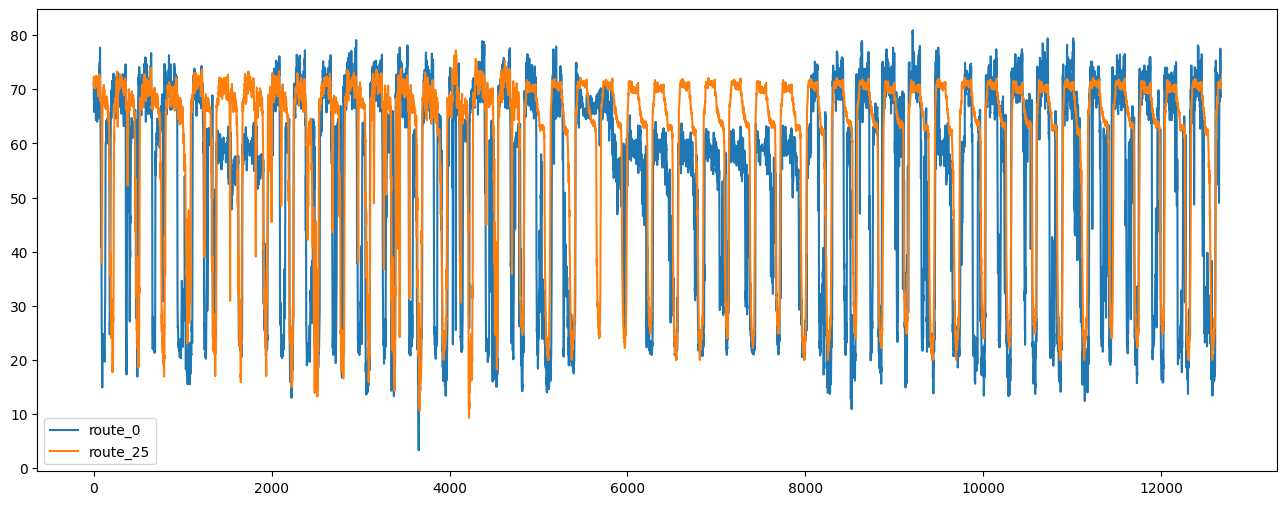

In [93]:
plt.figure(figsize=(16, 6))
plt.plot(speeds_array[:, [0, -1]])
plt.legend({'route_0', 'route_25'})

Text(0, 0.5, 'road number')

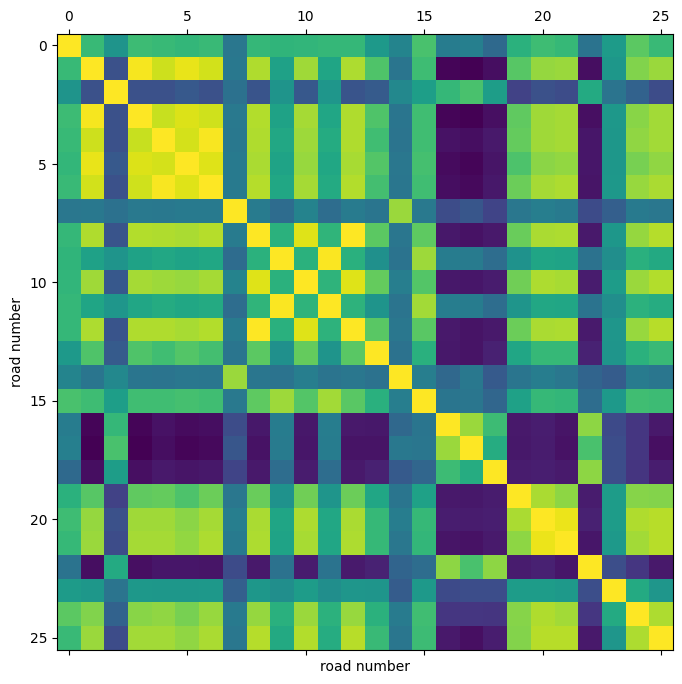

In [94]:
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(speeds_array.T), 0)
plt.xlabel('road number')
plt.ylabel('road number')

In [95]:
train_size, val_size = 0.5, 0.2

def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    num_time_steps = data_array.shape[0]
    num_time, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size)
    )

    train_array = data_array[:num_time]
    mean, std = train_array.mean(), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_time : (num_time + num_val)] - mean) / std
    test_array = (data_array[(num_time + num_val):] - mean) / std

    return train_array, val_array, test_array

train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f'train set size: {train_array.shape}')
print(f'val set size: {val_array.shape}')
print(f'test set size: {test_array.shape}')

train set size: (6336, 26)
val set size: (2534, 26)
test set size: (3802, 26)


In [96]:
batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False

def create_tf_dataset(
        data_array: np.ndarray,
        input_sequence_length: int,
        forecast_horizon: int,
        batch_size: int = 128,
        shuffle: bool = True,
        multi_horizon: bool = False
):
    inputs = keras.utils.timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size
    )

    target_offset = (
        input_sequence_length if multi_horizon else input_sequence_length + forecast_horizon - 1
    )

    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = keras.utils.timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()

train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

In [97]:
test_dataset = create_tf_dataset(
    test_array, input_sequence_length, forecast_horizon, batch_size=test_array.shape[0],
    shuffle=False, multi_horizon=multi_horizon
)

In [98]:
def compute_adjacency_matrix(route_distance: np.ndarray,
                             sigma2: float,
                             epsilon: float):
    num_routes = route_distance.shape[0]
    route_distance = route_distance / 10000.0
    w2, w_mask = (
        route_distance * route_distance,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )

    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

In [99]:

class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(root_distance, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 26, number of edges: 150


In [100]:
class GraphConv(layers.Layer):
    def __init__(self, in_feat, out_feat, graph_info: GraphInfo, aggregation_type='mean', combination_type='concat', activation: typing.Optional[str] = None, **kwargs):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = self.add_weight(
            initializer=keras.initializers.GlorotUniform(),
            shape=(in_feat, out_feat),
            dtype='float32',
            trainable=True
        )

        self.activation = tf.keras.activations.get(activation)

    def aggregate(self, neighbour_representations):
        aggregation_function = {
            'sum': tf.math.unsorted_segment_sum,
            'mean': tf.math.unsorted_segment_mean,
            'max': tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_function is None:
            return aggregation_function(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes
            )

        raise ValueError(f'Invalid aggregation function: {self.aggregation_type}')

    def compute_nodes_representations(self, features):
        return ops.matmul(features, self.weight)

    def compute_aggregated_messages(self, features):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return ops.matmul(aggregated_messages, self.weight)

    def update(self, node_representations, aggregated_messages):
        if self.combination_type == 'concat':
            h = ops.concatenate([node_representations, aggregated_messages], axis=-1)
        elif self.combination_type == 'mean':
            h = node_representations + aggregated_messages
        else:
            raise ValueError(f'Invalid combination type: {self.combination_type}')
        return self.activation(h)

    def call(self, features):
        nodes_representation = self.compute_nodes_representations(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)




In [101]:
class LSTMGC(layers.Layer):

    def __init__(
            self,
            in_feat,
            out_feat,
            lstm_units: int,
            input_seq_len: int,
            output_seq_len: int,
            graph_info: GraphInfo,
            graph_conv_params: typing.Optional[dict] = None,
            **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):

        inputs = ops.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )
        shape = ops.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        gcn_out = ops.reshape(
            gcn_out, (batch_size * num_nodes, input_seq_len, out_feat)
        )
        lstm_out = self.lstm(
            gcn_out
        )
        dense_output = self.dense(
            lstm_out
        )
        output = ops.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return ops.transpose(
            output, [1, 2, 0]
        )



In [103]:
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat =  10
lstm_units = 64
graph_conv_para = {'aggregation_type': 'mean',
                   'combination_type': 'concat',
                   'activation': None}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_para,
)

inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0002),
              loss=keras.losses.MeanSquaredError(),)

/home/cohben/.virtualenvs/machine_learning/lib/python3.10/site-packages/keras/src/layers/layer.py:1410: UserWarning: Layer 'lstmgc_17' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Exception encountered when calling GraphConv.call().

Invalid aggregation function: mean

Arguments received by GraphConv.call():
  • features=tf.Tensor(shape=(26, None, 12, 1), dtype=float32)''
  warnings.warn(
/home/cohben/.virtualenvs/machine_learning/lib/python3.10/site-packa

ValueError: Exception encountered when calling LSTMGC.call().

[1mCould not automatically infer the output shape / dtype of 'lstmgc_17' (of type LSTMGC). Either the `LSTMGC.call()` method is incorrect, or you need to implement the `LSTMGC.compute_output_spec() / compute_output_shape()` method. Error encountered:

Exception encountered when calling GraphConv.call().

[1mInvalid aggregation function: mean[0m

Arguments received by GraphConv.call():
  • features=tf.Tensor(shape=(26, None, 12, 1), dtype=float32)[0m

Arguments received by LSTMGC.call():
  • args=('<KerasTensor shape=(None, 12, 26, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_13>',)
  • kwargs=<class 'inspect._empty'>